Package Imports

In [6]:
from db import db

import pandas as pd
import numpy as np

import requests
from datetime import datetime

from sklearn.gaussian_process.kernels import RBF,  DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor

from scipy import stats
import pickle

from matplotlib import pyplot as plt

Get Training Data

In [ ]:
# Desired seasons
seasons = ['20152016', '20162017', '20172018', '20182019', '20192020', '20202021', '20212022', '20222023']

# Desired stats
team_stats = ['evGGARatio', 'shotsPerGame', 'shootingPctg']
opp_stats = ['shotsAllowed', 'savePctg']
cols = ['game_id', 'date', 'team_id', 'home_away', 'goals'] + team_stats + ['oppShotsAllowed', 'oppSavePctg']

# Create gamelog dataframe
nhl_gamelogs = []

# Base URL for NHL API
base_url = "https://statsapi.web.nhl.com"

# Iterate over seasons and collect gamelogs
for season in seasons:
    url = f"{base_url}/api/v1/schedule?season={season}&gameType=R"
    schedule_response = dict(requests.get(url).json())
    for date in schedule_response['dates']:
        for game in date['games']:
            try:
                # Get game id and date
                game_id = game['gamePk']
                date = datetime.strptime(game['gameDate'], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")

                # Get home team score and stats
                home_id = game['teams']['home']['team']['id']
                home_goals = game['teams']['home']['score']
                home_data = [game_id, date, home_id, 'H', home_goals]
                home_stats_url = f"{base_url}/api/v1/teams/{home_id}/stats?date={date}"
                home_stats_response = dict(requests.get(home_stats_url).json())
                home_stats_dict = home_stats_response['stats'][0]['splits'][0]['stat']
                home_data.extend([home_stats_dict[stat] for stat in team_stats])

                # Get away team score and stats
                away_id = game['teams']['away']['team']['id']
                away_goals = game['teams']['away']['score']
                away_data = [game_id, date, away_id, 'A', away_goals]
                away_stats_url = f"{base_url}/api/v1/teams/{away_id}/stats?date={date}"
                away_stats_response = dict(requests.get(away_stats_url).json())
                away_stats_dict = away_stats_response['stats'][0]['splits'][0]['stat']
                away_data.extend([away_stats_dict[stat] for stat in team_stats])

                # Add opponent stats
                home_data.extend([away_stats_dict[stat] for stat in opp_stats])
                away_data.extend([home_stats_dict[stat] for stat in opp_stats])

                # Add to dataframe
                nhl_gamelogs.append(home_data)
                nhl_gamelogs.append(away_data)
            except Exception as e:  # Catch a general exception and print the error message
                print(f"Error with game {game['gamePk']}: {str(e)}")
                continue

# Create dataframe of gamelogs
nhl_gamelogs_df = pd.DataFrame(nhl_gamelogs, columns=cols)

# Save dataframe to CSV
nhl_gamelogs_df.to_csv('data/nhl_gamelogs.csv', index=False)

Train Models

In [5]:
# Import the data we will use to make our model
nhl_gamelogs = pd.read_csv('data/nhl_gamelogs.csv')

# Remove the columns that we do not need to make our model
nhl_gamelogs.drop(columns=['game_id','team_id','date','home_away'], inplace=True)

# Sample 15% of game_x and game_Y
nhl_gamelogs_sample = nhl_gamelogs.sample(frac=0.15)
game_X_sample = nhl_gamelogs_sample.drop(columns=['goals'])
game_Y_sample = nhl_gamelogs_sample['goals']

# Fit the model to the sample and score results
kernel = DotProduct() + WhiteKernel()
gpr_xs = GaussianProcessRegressor(kernel=kernel, random_state=3)
gpr_xs.fit(game_X_sample, game_Y_sample)
gpr_xs.score(game_X_sample, game_Y_sample)

# Save the model
pickle.dump(gpr_xs, open('models\\nhl_gpr_model_xs.pkl', 'wb'))

Inference Data

In [22]:
# Desired stats
stat_cols = ['evGGARatio', 'shotsPerGame', 'shotsAllowed', 'shootingPctg', 'savePctg']

# Iterate over teams in db and collect season stats
league_stats = []
for team in db.nhl_teams.find():
    team_stats = []
    url = f"https://statsapi.web.nhl.com/api/v1/teams/{team['_id']}/stats"
    stats_response = dict(requests.get(url).json())
    stats_dict = stats_response['stats'][0]['splits'][0]['stat']
    team_stats.append(team['_id'])
    for stat in stat_cols:
        team_stats.append(stats_dict[stat])
    league_stats.append(team_stats)

# Create dataframe of season stats
league_stats = pd.DataFrame(league_stats, columns=['team_id']+stat_cols)

# Save dataframe to CSV
league_stats.to_csv('data/nhl_league_stats.csv', index=False)

Make Predictions

In [21]:
model = pickle.load(open('models\\nhl_gpr_model_xs.pkl', 'rb'))

# Function to predict score for a game given the stats of the two teams
def predict_score(team1, team2):
    # Team and opponent stats for inference
    team_stats = ['evGGARatio', 'shotsPerGame', 'shootingPctg']
    opp_stats = ['shotsAllowed', 'savePctg']
    
    # Get stats for team 1
    team1_id = db.nhl_teams.find_one({'abbr': team1})['_id']
    team1_stats = league_stats[league_stats['team_id']==team1_id]
    team1_stats.reset_index(inplace=True, drop=True)
    team1_off = team1_stats[team_stats]
    team1_def = team1_stats[opp_stats]
    team1_def.columns = ['oppShotsAllowed', 'oppSavePctg']
    
    # Get stats for team 2
    team2_id = db.nhl_teams.find_one({'abbr': team2})['_id']
    team2_stats = league_stats[league_stats['team_id']==team2_id]
    team2_stats.reset_index(inplace=True, drop=True)
    team2_off = team2_stats[team_stats]
    team2_def = team2_stats[opp_stats]
    team2_def.columns = ['oppShotsAllowed', 'oppSavePctg']

    # Concatenate team and opponent stats
    team1_input = pd.concat([team1_off, team2_def], axis=1)
    team2_input = pd.concat([team2_off, team1_def], axis=1)

    # Predict score for each team
    team1_preds = model.predict(team1_input, return_std=True)
    team2_preds = model.predict(team2_input, return_std=True)

    # Calculate win probability for each team
    team1_win_prob = stats.norm.cdf(team1_preds[0][0], loc=team2_preds[0][0], scale=team2_preds[1][0])
    team2_win_prob = stats.norm.cdf(team2_preds[0][0], loc=team1_preds[0][0], scale=team1_preds[1][0])

    # Create JSON output
    json_output = {
        team1: {
            'score': round(team1_preds[0][0], 3),
            'stdev': round(team1_preds[1][0], 3),
            'win_pct': round(team1_win_prob, 3),
        },
        team2: {
            'score': round(team2_preds[0][0], 3),
            'stdev': round(team2_preds[1][0], 3),
            'win_pct': round(team2_win_prob, 3),
        }
    }
    return json_output

# Predict score for a game
predict_score('CBJ', 'BOS')

{'CBJ': {'score': 2.802, 'stdev': 1.68, 'win_pct': 0.417},
 'BOS': {'score': 3.156, 'stdev': 1.683, 'win_pct': 0.583}}

Plot Predictions

In [7]:
def plot_score_preds(team1, team2):
    # Get predictions from API and determine expected winner
    preds = dict(requests.get(f'https://benrieth.pythonanywhere.com/nhl/score/{team1}/{team2}').json())
    if preds[team1]['score'] > preds[team2]['score']:
        winner = db.nhl_teams.find_one({'abbr': team1})
        loser = db.nhl_teams.find_one({'abbr': team2})
    else:
        winner = db.nhl_teams.find_one({'abbr': team2})
        loser = db.nhl_teams.find_one({'abbr': team1})
        
    # Plot the predicted score distributions
    x = np.linspace(preds[loser['abbr']]['score']-3.5*preds[loser['abbr']]['stdev'], preds[winner['abbr']]['score']+3.5*preds[winner['abbr']]['stdev'], 1000)
    w_dist = stats.norm.pdf(x, preds[winner['abbr']]['score'], preds[winner['abbr']]['stdev'])
    l_dist = stats.norm.pdf(x, preds[loser['abbr']]['score'], preds[loser['abbr']]['stdev'])
    plt.plot(x, w_dist, label=f"{winner['abbr']}", color=winner['color'])
    plt.plot(x, l_dist, label=f"{loser['abbr']}", color=loser['color'])

    # Calculate the winning odds
    win_mask = x > preds[loser['abbr']]['score']
    win_prob = stats.norm.cdf(preds[winner['abbr']]['score'], loc=preds[loser['abbr']]['score'], scale=preds[loser['abbr']]['stdev'])
    plt.fill_between(x[win_mask], w_dist[win_mask], color=winner['color'], alpha=0.5)
    plt.fill_between(x[~win_mask], w_dist[~win_mask], color=loser['color'], alpha=0.5)
    
    # Add legend, labels, and title and show plot
    plt.legend()
    plt.suptitle(f"{winner['short']} vs {loser['short']} Predicted Score Distribution", fontsize=13)
    plt.title(f"The {winner['short']} have a {win_prob:.2%} chance of winning", fontsize=10)
    plt.xlabel('Predicted Score')
    plt.ylabel('Probability')
    plt.gca().set_facecolor('#e0e0e0')
    plt.show()

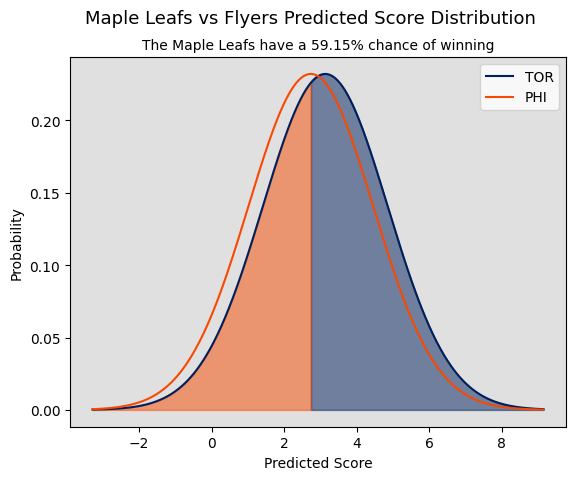

In [10]:
plot_score_preds('TOR', 'PHI')